# Practical Issues Overview
Up until this point we have focused mainly on theory and the two main functions of a neural networks:
1. How to **Predict**
2. How to **Train**
The question may arise, in practice, what else do we need to focus on? Well, we have mentioned that neural networks are nonlinear classifiers, which means that they can classify things when you can't draw a line between the two classes. Two famous examples of these are the **XOR** problem, and the **Donut Problem**. 

<img src="images/donut.png">

<br></br>
<img src="images/xor.png">

We have shown that **logistic regression** cannot solve those two problems unless you manually create new features. This can be time consuming and rather tedious, so ideally we would have an algorithm **learn** those features for us. However, the ability to learn these features automatically does not come for free. What you may have started to notice is that neural networks come with a variety of options: how many hidden units to use, how many hidden layers to use, the type of activation function, etc. These are **hyperparameters** and choosing them is not trivial, so we will discuss the process for this as well. 

This section is all about applying what we have already learned about neural networks in order to gain deeper insight into how they work, and what kind of baggage they come with. 

---
<br></br>
# 1. XOR Problem in Code 
Let's now go through the XOR problem in code, using a Neural Network to solve. This should be slightly simpler than the Neural Networks that we have been working with so far since this is a binary classification problem. We can start with our imports as always.

In [112]:
import numpy as np
import matplotlib.pyplot as plt

And now our forward function. Note, since this is only **binary classification** we are basically just doing two sigmoids in a row. 

In [113]:
def forward(X, W1, b1, W2, b2):
    Z = 1 / (1 + np.exp( -(X.dot(W1) + b1) ))   # output of hidden layer
    activation = Z.dot(W2) + b2                 # activation at output layer
    Y = 1 / (1 + np.exp(-activation))           # output at output layer
    return Y, Z

Our predict function will no longer be using `argmax`, since we are not using the `softmax`, instead it will just use `round` (anything less than 0.5 is classified as 0, anything great than 0.5 is classified as 1). 

In [114]:
def predict(X, W1, b1, W2, b2): 
    Y, _ = forward(X, W1, b1, W2, b2)
    return np.round(Y)

The derivatives are mostly the same. Note that `Z` is an **(N x M)** matrix. 

In [115]:
def derivative_w2(Z, T, Y):
    return (T - Y).dot(Z)

def derivative_b2(T, Y):
    return (T - Y).sum()

def derivative_w1(X, Z, T, Y, W2):
    dZ = np.outer(T-Y, W2) * (1 - Z * Z)
    return X.T.dot(dZ)

def derivative_b1(Z, T, Y, W2):
    dZ = np.outer(T - Y, W2) * (1 - Z * Z)
    return dZ.sum(axis=0)

Also note, regarding the derivative for $W_1$ and $b_1$, we utilize the `np.outer` function instead of the `np.dot` that we had been using in section 3. This may at first seem unexpected, but remember that in reality with our given configuration we are really just doing two sigmoids in a row. Let's look at our data for the XOR problem and this will make more sense. In the process we will make it a little more clear the architecture that we are working with.

We can see that our **X** has dimensions (4 x 2), meaning that we have 4 training examples, and each example has 2 dimenions. So our neural network is going to have an input layer containing **2 nodes**.

In [116]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])    # we can see that X is (4 x 2)
X

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

Our **Y** output has dimensions (4 x 1), meaning our output layer has **1 node**, containing our prediction value. 

In [117]:
Y = np.array([0, 1, 1, 0])                        # Y is (4 x 1)
Y

array([0, 1, 1, 0])

Our **W1** matrix has the shape (2 x 5), where each row holds the weights that map from a specific node in the input layer, to all of the nodes in the output layer. The appendix of section 3 training a neural network has a good visualization of this. Keep in mind, the shape of the **W1** tells us that we have **5 nodes** in our hidden layer, and hence the shape of **Z** should be (4 x 5). 

In [118]:
W1 = np.random.randn(2, 5)                        # W1 is (2 x 5)
W1

array([[ 0.93163268,  0.91146108,  0.50436259,  0.78321648,  1.31769257],
       [-1.10142287, -1.21103262, -1.32615   , -1.35481673,  1.29434063]])

Our **W2** matrix has shape (5 x 1), which is a column vector. This is because we need **W2** to be a size that brings us back to **1 node** for the output layer. It should be kept in mind that our final network architecture is 2 input nodes, 5 hidden layer nodes, and 1 output node.

In [119]:
W2 = np.random.randn(5)                           # W2 is (5 x 1)
W2.shape

(5,)

Let's calculate **Z** via the dot product to ensure that it is in fact (4 x 5).

In [120]:
X

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [121]:
W1

array([[ 0.93163268,  0.91146108,  0.50436259,  0.78321648,  1.31769257],
       [-1.10142287, -1.21103262, -1.32615   , -1.35481673,  1.29434063]])

In [122]:
Z = X.dot(W1)                                     # Z is (4 x 5) 
Z

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.10142287, -1.21103262, -1.32615   , -1.35481673,  1.29434063],
       [ 0.93163268,  0.91146108,  0.50436259,  0.78321648,  1.31769257],
       [-0.16979019, -0.29957154, -0.8217874 , -0.57160025,  2.61203321]])

Great, **Z** is (4 x 5) and each row represents the values of the nodes (5 nodes total) at **Z** for a given training example (4 training examples total). Remember: the first column of **X** holds the value for **input node 1** at a specific training example, and the second column holds the value for **input node 2**. When we perform the dot product, we start by taking the 1st column of **W2**, which holds the weight mapping from **input node 1** to **hidden node 1**, and the weight mapping from **input node 2** to **hidden node 1**, and applying it to **X**. The result is the dot product, and the first column of our **Z** matrix is the result.

Now, with that said lets move on to the calculation of our prediction **pY**. We should be expecting a shape of (4 x 1), since we want it to match our targets, **Y**, since we want to have 1 prediction for each of the 4 examples. We will apply the column vector **W2** to each row of **Z**, performing the dot product and ending up with a (4 x 1) matrix.

In [123]:
W2              # quickly visualizing W2

array([ 1.0446353 ,  0.81210986, -0.57296673,  0.26730075, -0.52501608])

In [124]:
pY = Z.dot(W2)                                    # pY is (4 x 1)
pY

array([ 0.       , -2.4159301,  0.9419845, -1.4739456])

Now that we have gone through the **forward prediction** step (keep in mind that no activation was applied since this was just to demonstrate the shapes of the matrices and element wise operations would not affect that, so we didn't worry about them for now), the question still remains: why was the `np.outer` function used instead of `np.dot` in our derivative for **W2**? Well, lets look at the shape of (Y - pY) and W2 again:

In [125]:
Y - pY

array([0.       , 3.4159301, 0.0580155, 1.4739456])

In [126]:
W2

array([ 1.0446353 ,  0.81210986, -0.57296673,  0.26730075, -0.52501608])

So (Y - pY) has a shape (4 x 1), and W2 has a shape (5 x 1). Now, we need to end up with a shape that matches **Z**, (4 x 5). If you look at the numpy tutorial, you can see that if you have two vectors, the first a column vector and the second a row vector, if they have the same size you can perform the dot product. However, because these dimensions do not match up, the outer product allows us to apply the term representing our error (Y - pY) to each weight value in W2.

In [127]:
dZ = np.outer((Y - pY), W2)
dZ

array([[ 0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [ 3.56840117,  2.77411052, -1.9572143 ,  0.91308068, -1.79341822],
       [ 0.06060504,  0.04711496, -0.03324095,  0.01550759, -0.03045907],
       [ 1.53973561,  1.19700576, -0.84452179,  0.39398676, -0.77384514]])

In [128]:
dZ.shape

(4, 5)

Excellent, our shape is (4 x 5) which matches **Z**. Now lets get back to the remaining functions that we needed to define. The **cost function** is next on our list. In this case we are using the **cross entropy**, which is equivalent to the **negative log likelihood**.

In [129]:
def get_log_likelihood(T, Y):
    return np.sum(T * np.log(Y) + (1 - T)*np.log(1 - Y))

Now we can write a function to actually test the XOR problem.

In [130]:
def test_xor():
    # create XOR data
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    Y = np.array([0, 1, 1, 0])
    W1 = np.random.randn(2, 5)
    b1 = np.zeros(5)
    W2 = np.random.randn(5)
    b2 = 0
    
    LL = []                       # keep track of log-likelihoods
    
    # set our hyper parameters
    learning_rate = 1e-2
    regularization = 0.
    last_error_rate = None
    
    for i in range(30000):
        pY, Z = forward(X, W1, b1, W2, b2)
        ll = get_log_likelihood(Y, pY)
        prediction = predict(X, W1, b1, W2, b2)
        er = np.mean(prediction != Y)

        LL.append(ll)
        W2 += learning_rate * (derivative_w2(Z, Y, pY) - regularization * W2)
        b2 += learning_rate * (derivative_b2(Y, pY) - regularization * b2)
        W1 += learning_rate * (derivative_w1(X, Z, Y, pY, W2) - regularization * W1)
        b1 += learning_rate * (derivative_b1(Z, Y, pY, W2) - regularization * b1)
        if i % 1000 == 0:
            print(ll)

    print("final classification rate:", np.mean(prediction == Y))
    plt.plot(LL)
    plt.show()        

-5.4058365611452395
-2.462538393784536
-1.7262100187732923
-1.3721060642312712
-1.0856836220696875
-0.9105181312830212
-0.7958018660122069
-0.7031967562796098
-0.6248922290146786
-0.5598826202731333
-0.5071566863376937
-0.46460595307630437
-0.43092943630015706
-0.40578397671486854
-0.3878127281614125
-0.37119257248625037
-0.34613508076318533
-0.31418097643709714
-0.2848552838883065
-0.26104101815620917
-0.2417888124981114
-0.22584032122971961
-0.2123145531869809
-0.20064753711804298
-0.1904746408603161
-0.18155457256053462
-0.17372623119141228
-0.16688161965716874
-0.16094305222566485
-0.15583812904433347
('final classification rate:', 1.0)


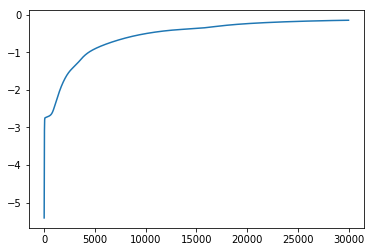

In [131]:
test_xor()

Now let's write out the code that will run through the donut problem. Some things to note are that we explicitly define 8 hidden units and use that to define the size of our weight matrices. 

In [144]:
def forward(X, W1, b1, W2, b2):
    # sigmoid
    # Z = 1 / (1 + np.exp( -(X.dot(W1) + b1) ))

    # tanh
    # Z = np.tanh(X.dot(W1) + b1)

    # relu
    Z = X.dot(W1) + b1
    Z = Z * (Z > 0)

    activation = Z.dot(W2) + b2
    Y = 1 / (1 + np.exp(-activation))
    return Y, Z


def predict(X, W1, b1, W2, b2):
    Y, _ = forward(X, W1, b1, W2, b2)
    return np.round(Y)


def derivative_w2(Z, T, Y):
    # Z is (N, M)
    return (T - Y).dot(Z)

def derivative_b2(T, Y):
    return (T - Y).sum()


def derivative_w1(X, Z, T, Y, W2):
    # dZ = np.outer(T-Y, W2) * Z * (1 - Z) # this is for sigmoid activation
    # dZ = np.outer(T-Y, W2) * (1 - Z * Z) # this is for tanh activation
    dZ = np.outer(T-Y, W2) * (Z > 0) # this is for relu activation
    return X.T.dot(dZ)


def derivative_b1(Z, T, Y, W2):
    # dZ = np.outer(T-Y, W2) * Z * (1 - Z) # this is for sigmoid activation
    # dZ = np.outer(T-Y, W2) * (1 - Z * Z) # this is for tanh activation
    dZ = np.outer(T-Y, W2) * (Z > 0) # this is for relu activation
    return dZ.sum(axis=0)


def get_log_likelihood(T, Y):
    return np.sum(T*np.log(Y) + (1-T)*np.log(1-Y))



def test_donut():
    # donut example
    N = 1000
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))

    n_hidden = 8
    W1 = np.random.randn(2, n_hidden)
    b1 = np.random.randn(n_hidden)
    W2 = np.random.randn(n_hidden)
    b2 = np.random.randn(1)
    LL = [] # keep track of log-likelihoods
    learning_rate = 0.00005
    regularization = 0.2
    last_error_rate = None
    for i in range(3000):
        pY, Z = forward(X, W1, b1, W2, b2)
        ll = get_log_likelihood(Y, pY)
        prediction = predict(X, W1, b1, W2, b2)
        er = np.abs(prediction - Y).mean()
        LL.append(ll)
        W2 += learning_rate * (derivative_w2(Z, Y, pY) - regularization * W2)
        b2 += learning_rate * (derivative_b2(Y, pY) - regularization * b2)
        W1 += learning_rate * (derivative_w1(X, Z, Y, pY, W2) - regularization * W1)
        b1 += learning_rate * (derivative_b1(Z, Y, pY, W2) - regularization * b1)
        if i % 300 == 0:
            print("i:", i, "ll:", ll, "classification rate:", 1 - er)
    plt.plot(LL)
    plt.show()

('i:', 0, 'll:', -1483.7333411539862, 'classification rate:', 0.53)
('i:', 300, 'll:', -304.78580984193627, 'classification rate:', 0.969)
('i:', 600, 'll:', -201.77128229516939, 'classification rate:', 0.987)
('i:', 900, 'll:', -142.32115738962548, 'classification rate:', 0.991)
('i:', 1200, 'll:', -106.2165370236086, 'classification rate:', 0.993)
('i:', 1500, 'll:', -83.82530683283403, 'classification rate:', 0.992)
('i:', 1800, 'll:', -68.82802128419723, 'classification rate:', 0.993)
('i:', 2100, 'll:', -57.979539772564465, 'classification rate:', 0.993)
('i:', 2400, 'll:', -50.08223521073666, 'classification rate:', 0.993)
('i:', 2700, 'll:', -43.97950461278596, 'classification rate:', 0.993)


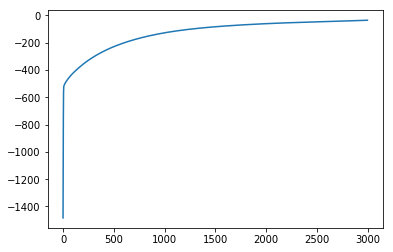

In [145]:
test_donut()

---
<br></br>
# 2. Neural Networks for Regression
We are now going to take a brief look at how to utilize Neural Networks in a Regression problem. In general, they are used for classification, for a variety of reasons (most of the famous problems they have solved have been classification, they often perform better in that setting, etc). However, they can sometimes be very effective in a regression scenario, and are even utilized in certain state of the art applications such as deep reinforcement learning. 

## 2.1 Neural Network Binary Classification Structure 

<img src="images/logistic-regression-arch.png">

For Binary classification we will have a stack of nonlinear hidden layers, followed by a logistic regression at the end. We can call this logistic regression, because this takes on the exact form of logistic regression; aka a linear transformation, $Wx+b$, and a sigmoid (shown in the circle on the right). For the hidden layers, we are not going to call them logistic regression since they still take in a linear transformation, but the activation function is not necessarily a sigmoid, it could be **tanh**, **relu**, etc. Still, the concept of stacking layers of neurons is important to consider since that is what lead us to these new structures in the first place. 

<br></br>
## 2.2 Neural Network Multi-class Classification Structure 

<br></br>
<img src="images/multi-class-arch.png">

For multi-class classification we have nearly the same thing, only now the output layer has more units, one corresponding to each class. However, notice that everything up until the last layer is the same as before. We have stacks on **linear transformations**, along with **nonlinear activation functions**, and at the end we have a **multi-class logistic regression**, which is a **linear transformation** and a **softmax**. 

<br></br>
## 2.3 Neural Network Regression Structure 

<br></br>
<img src="images/regression-arch.png">

Finally we have the regression scenario. Again, notice how everything up until the last layer is the same as before. We have stacks on **linear transformations**, along with **nonlinear activation functions**, and at the end we have **only** a **linear transformation**, and this is of course exactly **linear regression**. 

<br></br>
## 2.4 The Lesson
We know that from prior studies that if we just consider *just* linear models, we have **logistic regression** for classification, and **linear regression** for **regression**. In a sense we can consider everything up until the last layer just the feature extraction/transformation, where we are transforming the input into something different. After that, we are just doing what we already know: logistic regression for classification, and linear regression for regression. 

<br></br>
<img src="images/high-level-arch.png">